# Machine Learning Basics in Python 

### GDAA2000 Data Mining Fundamentals
### Project 3 - Geospatial Data Analytics with Python
### By: Tiana Gallo

## Introduction

This notebook presents a simple workflow for performing basic Machine Learning to predict a categorical target variable using a small spatial dataset. The objective of this notebook is to help gain familiarity with the key sections making up a typical Machine Learning project, including:

- Data Importing
- Data Cleaning and Exploration
- Building a classification model
- Evaluating model results
- Saving a trained model for later use

## Importing Spatial Data

The data used in this notebook is a sample of Dissemination Area data from the Business Analyst Canada 2023 dataset, provided by Esri Canada. It is for educational and demonstration purposes only, and should not be shared without permission.

The data comprises a sample of Dissemination Areas corresponding to the Province of Newfoundland and Labrador. The data was initially exported from ArcGIS Pro as a Shapefile. It has been enriched with several generic demographic and spending variables, intended to serve as predictors in our model building exercise.

As a spatial data set, we will use the GeoPandas package to import it into our notebook.

In [1]:
import pandas as pd
import geopandas as gpd

# Get the path to the Shapefile 
shapefile_path = r"C:\GDAA2000\Machine Learning Basics\data\DisseminationAreas_EnrichLayer.shp"

# Use GeoPandas to read/import the data
Newfoundland_DAs = gpd.read_file(shapefile_path)

# Examine the data to ensure it was imported correctly
Newfoundland_DAs.head()

,ID,NAME,ECYPTAPOP,RG_NAME,RG_ABBREV,HasData,aggregatio,FiveYearPo,HouseholdI,ChildrenAt,Tenure_ECY,MaritalSta,Population,LabourForc,Shape_Leng,Shape_Area,geometry
0,10100082,"10100082, NL",754,Newfoundland and Labrador / Terre-Neuve-et-Lab...,NL,1,CentroidsInPolygon:CAN.DA,37.1,186587.69,16.02,14.84,69.13,3.7,5.08,4.901943e+06,2.349376e+11,"POLYGON ((-7375715.316 7361437.015, -7375096.1..."
1,10100083,"10100083, NL",586,Newfoundland and Labrador / Terre-Neuve-et-Lab...,NL,1,BlockApportionment:CAN.DA;PointsLayer:CAN.Bloc...,34.8,169767.44,15.74,73.87,67.44,-0.3,0.00,1.857211e+04,8.090380e+06,"POLYGON ((-7444529.352 6966386.505, -7444534.2..."
2,10100084,"10100084, NL",417,Newfoundland and Labrador / Terre-Neuve-et-Lab...,NL,1,BlockApportionment:CAN.DA;PointsLayer:CAN.Bloc...,40.7,165217.39,14.17,94.19,59.50,-6.5,5.87,5.805850e+03,9.467341e+05,"POLYGON ((-7443731.080 6965058.314, -7443656.8..."
3,10100085,"10100085, NL",393,Newfoundland and Labrador / Terre-Neuve-et-Lab...,NL,1,BlockApportionment:CAN.DA;PointsLayer:CAN.Bloc...,38.5,175694.44,15.38,86.45,67.70,-5.8,6.92,7.651806e+04,1.191790e+08,"POLYGON ((-7442975.777 6961260.824, -7442901.1..."
4,10100086,"10100086, NL",525,Newfoundland and Labrador / Terre-Neuve-et-Lab...,NL,1,BlockApportionment:CAN.DA;PointsLayer:CAN.Bloc...,36.0,138839.29,22.30,83.57,62.90,8.0,2.77,4.042446e+03,6.745430e+05,"POLYGON ((-7443720.393 6965131.030, -7443789.4..."


The `ID` variable represents the index assigned to each row in the feature class in ArcGIS Pro. `NAME` represents the actual unique code assigned to each Dissemination Area by the Government of Canada. For this project, we will being using `Population_Change` as our target variable, with the other columns serving as predictors. The `Population_Change` column is the percentage of population change of a Dissemination Area from 2018 - 2023. The population in Canada and specifically the Atlantic provinces has been steadily increasing over the last few decades, but the province of Newfoundland and Labrador tends to be an anomaly and I want to use this project as a way to investigate further into why that is. Note the `geometry` column as this indicates that we are indeed working with a spatial data frame.  

## Data Cleaning and Exploration

This section demonstrates the process of cleaning and exploring the data in advance of building a classification model. The process is quite iterative, requiring multiple clean-up steps and constant verification that the specified changes have been correctly implemented. In normal situations, when you have built up confidence in your workflows, you will be able to streamline this process and avoid the admittedly excessive checking and re-checking of the data. However, at this stage it is good practice to be pedantic with your data cleaning and preparation workflow. 



### Fixing Variable Names

Ensure that the column names have been imported correctly, and, if not, fix them.

In [2]:
# Print the variable names
print(Newfoundland_DAs.dtypes)

Index(['ID', 'NAME', 'ECYPTAPOP', 'RG_NAME', 'RG_ABBREV', 'HasData',
       'aggregatio', 'FiveYearPo', 'HouseholdI', 'ChildrenAt', 'Tenure_ECY',
       'MaritalSta', 'Population', 'LabourForc', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


It looks like the following variables have issues:

- `FiveYearPo` should be `Median_Age`
- `HouseholdI` should be `Household_Income`
- `ChildrenAt` should be `ChildrenUnder_5`
- `LabourForc` should be `Unemployment`
- `Tenure_ECY` should be `Percentage_Home_Owned`
- `MartialSta` should be `Married_CommonLaw`
- `ECYPTAPOP`  should be `Total_Population`
- `Population` should be `Population_Change`


There are also some columns that do not affect the taget variable, so we can drop those. Let's implement these changes.

In [3]:
# Fix variable names
Newfoundland_DAs = Newfoundland_DAs.rename(columns={
    'ECYPTAPOP': 'Total_Population',
    'FiveYearPo': 'Median_Age',
    'HouseholdI': 'Household_Income',
    'ChildrenAt': 'ChildrenUnder_5',
    'Tenure_ECY': 'Percentage_Home_Owned',
    'MaritalSta': 'Married_CommonLaw',
    'LabourForc': 'Unemployment',
    'Population': 'Population_Change'
})

# Drop unnecessary columns
Newfoundland_DAs = Newfoundland_DAs.drop(columns = ['RG_NAME', 'RG_ABBREV', 'HasData', 'aggregatio'])

# Print the updated variable names to verify changes
print(Newfoundland_DAs.columns)

Index(['ID', 'NAME', 'Total_Population', 'Median_Age', 'Household_Income',
       'ChildrenUnder_5', 'Percentage_Home_Owned', 'Married_CommonLaw',
       'Population_Change', 'Unemployment', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


### Data Audit

Ensure that the variables have been parsed correctly. This means verifying the data types for each variable, which are sometimes incorrect.

In [4]:
# Verify the data types of each variable
print(Newfoundland_DAs.dtypes)

ID                         object
NAME                       object
Total_Population            int64
Median_Age                float64
Household_Income          float64
ChildrenUnder_5           float64
Percentage_Home_Owned     float64
Married_CommonLaw         float64
Population_Change         float64
Unemployment              float64
Shape_Leng                float64
Shape_Area                float64
geometry                 geometry
dtype: object


Data audits also entail checking to see if there are any missing data. 

In [5]:
# Check for missing data
missing_data = Newfoundland_DAs.isnull().sum()

# Print the summary of missing data
print(missing_data[missing_data > 0])

Series([], dtype: int64)


This dataset does not have any missing data. In the event of missing data, it would be critical to decide upon a data imputation strategy. Alternatively, rows with missing data could be removed from the dataset. This latter option is less than ideal when the dataset is quite small, as in the case with the current data. 

### Mapping the Target Variable

Since we have a spatial data frame, we can inspect the data using a map to get a sense of the spatial distribution of our target and predictor variabbles. 

This next code chunk presents a template for creating a simplified choropleth map. Adding a basemap and other cartographic details (e.g., scales, north arrows) are desirable, though take some time to get right. 

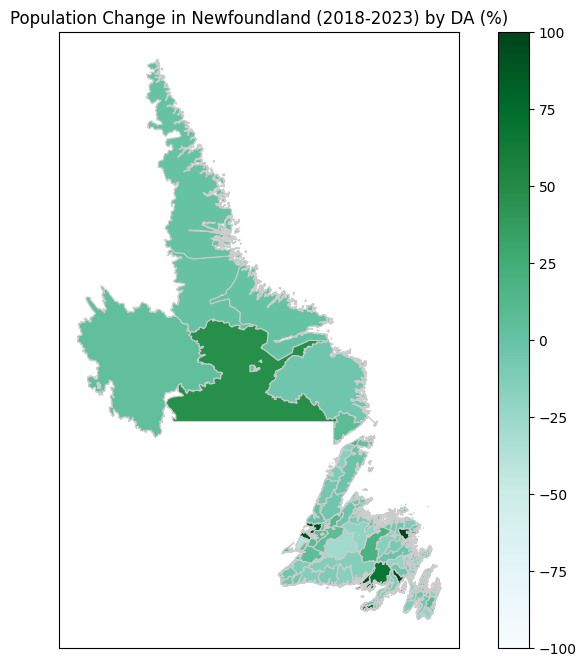

In [6]:
from mapclassify import NaturalBreaks
import matplotlib.pyplot as plt

# Classify the data using natural breaks
classifier = NaturalBreaks(Newfoundland_DAs['Population_Change'], k=5)

# Create the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

Newfoundland_DAs.plot(column='Population_Change', cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8',
                 legend=True, legend_kwds={'label': "", 'orientation': "vertical"},
                 vmin = -100, vmax = 100)

# Remove axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Add title
plt.title('Population Change in Newfoundland (2018-2023) by DA (%)')

# Show the plot
plt.show()


There appears to be many Dissemination Areas with no change (0%) in population accross Newfoundland and Labrador, but some smaller areas on the island that have a significant increase. There are also many areas in Central Newfoundland that appear to have a larger decrease in population. Notably, there is a large Dissemination Area in Labrador that has a greater population increase which is worth investigating as the rest of Labrador seems to have very little change in population over the last few years. The Dissemination Area that as the large population increase includes the town of Happy Valley-Goose Bay which has seen an increase in economic activity over the last few years which in turn would have a demand for a larger work force. 

### Exploring the Distribution of `Population_Change`

Exploratory data analysis (EDA) of your variables includes examing the distribution of values within each variable. For this exercise, we will focus only on the target variable, `Population_Change`, but in practice all variables should be explored and assessed, even if this exploration and assessment is done automatically using a data exploration script.

The key is to look for skew or other non-normal distributions, and to determine if these issues can be fixed using legitimate approaches such as trimming outliers or other data transformations. 

Let's start by exploring the distribution of `Population_Change`.

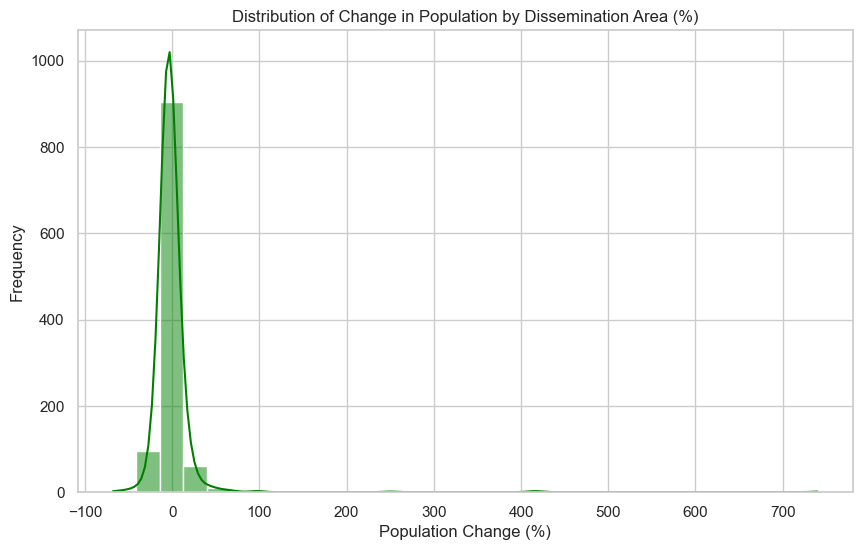

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use the 'style' argument to ensure that a grid appears (this is optional) in the plot
sns.set(style="whitegrid")

# Create a histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=Newfoundland_DAs, x='Population_Change', bins=30, kde=True, color='green')
plt.title('Distribution of Change in Population by Dissemination Area (%)')
plt.xlabel('Population Change (%)')
plt.ylabel('Frequency')

plt.show()

It appears that `Population_Change` has a positively skewed distribution. However, there is a spike of polygons with very high population change, which be connected to certain polygons that have zero or nearly zero population values. We can investigate this further to see if the outliers can be disregarded. 

Let's start by dealing with the low values first by exploration the `Total_Population` variable. For starters, let's find out if any polygons have zero population.

In [8]:
# Count the DAs where Population is equal to 0
population_zero = (Newfoundland_DAs['Total_Population'] == 0).sum()

print("DAs with zero population:", population_zero)

DAs with zero population: 9


There are 9 DAs with nobody living in them in this dataset. Let's take a look at where these polygons are on the map.

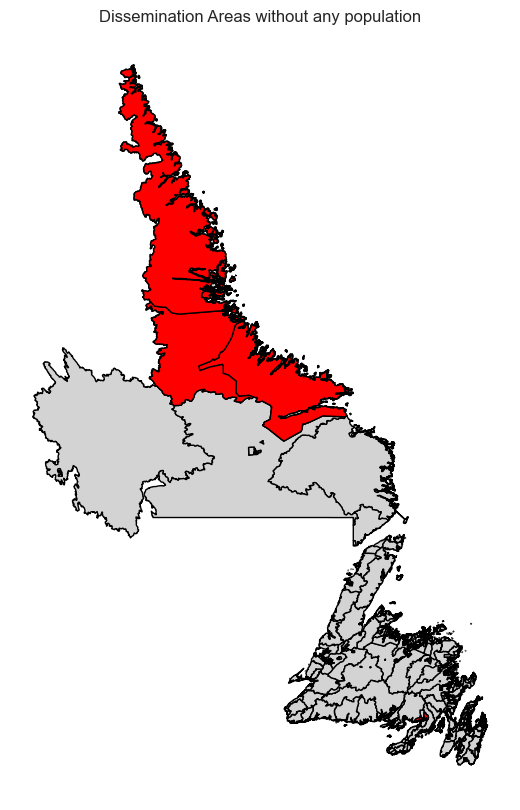

In [9]:
# Filter the data to include only DAs where Population is equal to 0
zero_population = Newfoundland_DAs[Newfoundland_DAs['Total_Population'] == 0]

ax = Newfoundland_DAs.plot(color='lightgrey', edgecolor='black', figsize=(10, 10))
zero_population.plot(ax=ax, color='red', edgecolor='black')
ax.set_axis_off()
ax.set_title('Dissemination Areas without any population')

plt.show()

There are some large Dissemination Areas in Labrador that have zero population, and some smaller, rural areas in Newfoundland that have no population, but these are a bit more difficult to see in the map.

Since these polygons have no population, and are peripheral to our study area, they should be filtered out of our dataset.

In [10]:
# Filter Halifax_DAs to exclude rows where Population == 0
Newfoundland_DAs_filtered = Newfoundland_DAs[Newfoundland_DAs['Total_Population'] != 0]

Here we are establishing the practicing of creating a new data frame with a descriptive name (e.g., `Newfoundland_DAs_filtered`) to reflect the operation performed on the input data, rather than simply overwriting the original data frame. This is not an efficient way to go about data cleaning, but it does keep things compartmentalized to a degree, and it also makes it a bit easier to catch mistakes. As a result, we continue to use this approach for the subsequent data preparation operations. 

Now that we have filtered out the problematic DAs with zero population, we can review the results to see if things have improved.

In [11]:
# Verify that there are no more DAs with zero population
population_zero = (Newfoundland_DAs_filtered['Total_Population'] == 0).sum()

print("DAs with zero population:", population_zero)

DAs with zero population: 0


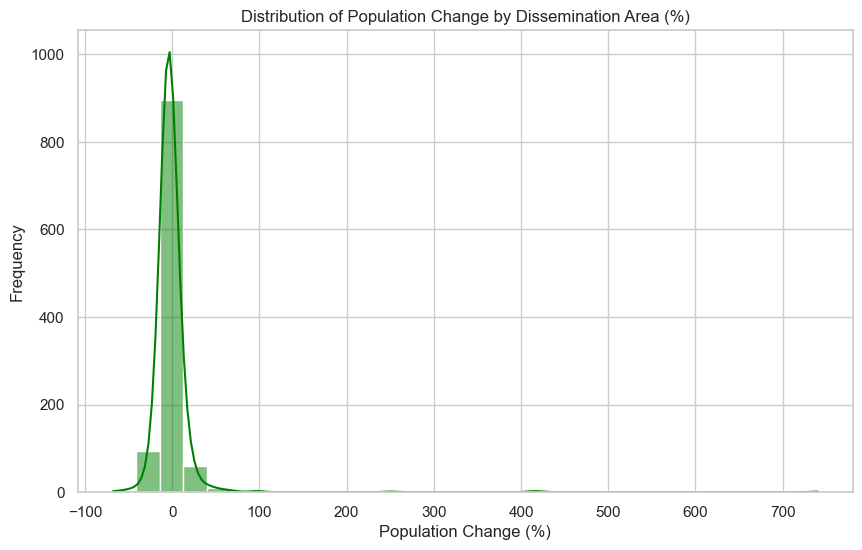

In [15]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=Newfoundland_DAs_filtered, x='Population_Change', bins=30, kde=True, color='green')
plt.title('Distribution of Population Change by Dissemination Area (%)')
plt.xlabel('Population Change (%)')
plt.ylabel('Frequency')
plt.show()

This updated plot still looks similar to the previous and there is a definite positive skew, however, and this is likely the product of several outliers. Let's deal with that now. 

### Trimming Outliers

There are many ways to determine if a value represents an outlier. One way is to use standard deviations, setting a specific threshold value beyond which values are considered outliers. For example, in this demonstration, we will use the threshold value of 3 standard deviations. That means, if a given DA has a `Population_Change` value that is greater than or less than 3 standard deviations from the mean `Population_Change` value, it will be considered an outlier and will be trimmed from the dataset. 

A simple way to implement this approach is to convert the given numeric variable to a scaled version of itself using the z-score transformation, and then trimming any rows with values less than -3 or greater than 3. This works because z-score transformations rescale the numeric data so that they have means of zero and standard deviations in integer increments. 

Here is the implementation of this approach, using 3 standard deviations as our threshold. Note: 3 is an arbitrary selection, and this parameter can be modified. 

In [12]:
from scipy import stats

# Calculate z-scores for the 'Population_Change' variable
z_scores = stats.zscore(Newfoundland_DAs_filtered['Population_Change'])

# Set the threshold for outliers (use a value that makes sense to you)
threshold = 3

# Trim the outliers
Newfoundland_DAs_trimmed = Newfoundland_DAs_filtered[(z_scores < threshold) & (z_scores > -threshold)]

Now that we have implemented the trimming operation, let us compare the input and output data frames to get a sense of how many samples were trimmed.

In [13]:
# Verify the dimensions of the input and output data frames
print("Dimensions of Newfoundland_DAs_filtered:", Newfoundland_DAs_filtered.shape)
print("Dimensions of Newfoundland_DAs_trimmed:", Newfoundland_DAs_trimmed.shape)


Dimensions of Newfoundland_DAs_filtered: (1073, 13)
Dimensions of Newfoundland_DAs_trimmed: (1068, 13)


It looks like 13 instances were trimmed. Now, let's see if this makes a difference in the distribution of our target variable.

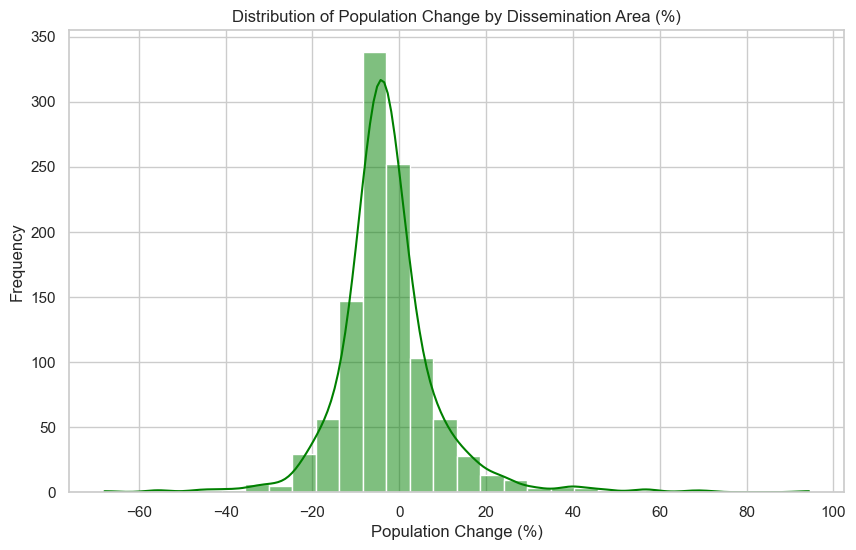

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=Newfoundland_DAs_trimmed, x='Population_Change', bins=30, kde=True, color='green')
plt.title('Distribution of Population Change by Dissemination Area (%)')
plt.xlabel('Population Change (%)')
plt.ylabel('Frequency')
plt.show()

Based on this histogram, it appears that our trimming operation was a success and the data is normally distributed. The highest occurance of population change is just below 0%, meaning that there are the most Dissemination Areas that have decreased slightly in population since 2018. The second highest occurance is 0%, indicating there are also a lot of areas that have had a constant population in Newfoundland since 2018.

### Discretizing Target 

Since I am aiming to build a classification model, I need to discretize the target variable. Here, I adopt the `qcut` method and set the desired quantiles to 4, as I want my target variable to be binned into four categories: Very Low, Low, High, and Very High. These are somewhat arbitrary, and in the end, I mostly just want to ensure that I have a balanced target variable, with approximately equal counts across all four of the resulting class labels. This may not always be feasible in real-life modelling scenarios. 

In [15]:
# Create labels for quantiles
labels = ["Very Low", "Low", "High", "Very High"]

# Discretize Population_Change into four quantiles with equal counts and assign custom labels
Newfoundland_DAs_binned = Newfoundland_DAs_trimmed.copy()  # Make a copy to avoid modifying the original
Newfoundland_DAs_binned['Pop_Change_Quantiles'] = pd.qcut(Newfoundland_DAs_trimmed['Population_Change'], q=4, labels=labels)

# Preview the results
print(Newfoundland_DAs_binned[['Population_Change', 'Pop_Change_Quantiles']].head())

   Population_Change Pop_Change_Quantiles
0                3.7            Very High
1               -0.3                 High
2               -6.5                  Low
3               -5.8                  Low
4                8.0            Very High


Reviewing the output, I can see that a new variable is now present, representing the binned version of my target variable. Additionally, the numeric values look consistent compared to the class labels, so I am confident that this worked correctly and we can proceed.

To ensure that the new variable is balanced, I will create a quick bar plot.

C:\Users\tiana\AppData\Local\Temp\ipykernel_33276\3417294391.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Newfoundland_DAs_binned, x='Pop_Change_Quantiles', order=labels, palette='viridis')


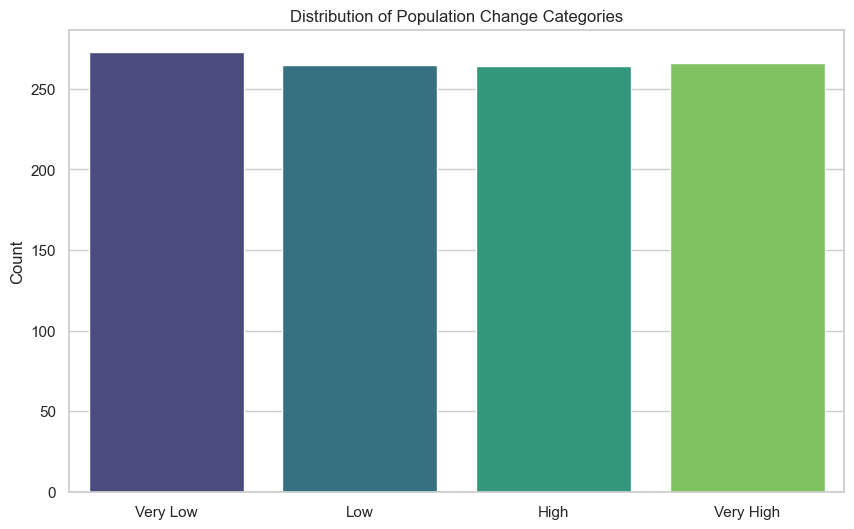

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=Newfoundland_DAs_binned, x='Pop_Change_Quantiles', order=labels, palette='viridis')
plt.title('Distribution of Population Change Categories')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

Good enough! You can see that it is not perfectly even accross all categories, but this is expected. Now, let's check that this variable's data type has changed.

In [17]:
print(Newfoundland_DAs_binned.dtypes)

ID                         object
NAME                       object
Total_Population            int64
Median_Age                float64
Household_Income          float64
ChildrenUnder_5           float64
Percentage_Home_Owned     float64
Married_CommonLaw         float64
Population_Change         float64
Unemployment              float64
Shape_Leng                float64
Shape_Area                float64
geometry                 geometry
Pop_Change_Quantiles     category
dtype: object


`Pop_Change_Quantiles` is our new target variable, and it appears to be registered as a categorical variable, exactly as desired. 

### Variable Selection

The next step in data preparation is to remove any unnecessary or redundant variables. In this case, we should remove the `NAME`, `ID`, and `geometry` columns, as the first two are not true predictors, and the last is not a compatible data type for our modelling options. 

Removing the `geometry` column means that our analysis is not considering the geographic patterning of our DAs in the modelling process. Encoding distances and other spatial relationships is possible, but these need to be generated independently in advance in order to be used as predictors. For example, we wanted to account for whether or not a given pair of polygons were neighbours, we would need to calculate this using GeoPandas, adding a logical variable for all possible pairs/combinations of DAs to our dataset, and assigning True or False values for each instance. This would clearly add a lot of additional complexity to our dataset and subsequent model. Similar approaches can be adopted to encode spatial relationships in a format that can be used by typical statistical learning packages like `scikit-learn`, and this will inevitably entail creating new variables with compatible data types (e.g., numeric, categorical, logical). For simplicity, in this example, we remove `geometry` and do not consider spatial relationships explicitly in the modelling process.

In [18]:
# Selecting predictors and binned target variable from Halifax_DAs_binned
Newfoundland_DAs_select = Newfoundland_DAs_binned[['Household_Income', 'Median_Age', 
                                         'ChildrenUnder_5', 'Unemployment', 
                                         'Percentage_Home_Owned', 'Married_CommonLaw',
                                         'Pop_Change_Quantiles']].copy()

print(Newfoundland_DAs_select.dtypes)


Household_Income          float64
Median_Age                float64
ChildrenUnder_5           float64
Unemployment              float64
Percentage_Home_Owned     float64
Married_CommonLaw         float64
Pop_Change_Quantiles     category
dtype: object


### Re-Scaling the Data

The final step in preparation for modelling is to re-scale our data using z-score transformations. This will render all of our numeric predictors on the same scale, preventing any bias in the model building phase. While this step may not be necessary, in that most modelling modules will scale your data automatically, it is good practice to explicitly re-scale your data, ensuring that you are not relying on any hidden data processing operations.

We will use the `StandardScaler` module from `scikit-learn` to scale our data. 

In [19]:
from sklearn.preprocessing import StandardScaler

# Set the scaler
scaler = StandardScaler()

# Select only the numeric variables
numeric_columns = ['Household_Income', 'Median_Age', 
                    'ChildrenUnder_5', 'Unemployment', 
                    'Percentage_Home_Owned', 'Married_CommonLaw']

# Transform the selected variables
Newfoundland_DAs_scaled = Newfoundland_DAs_select.copy()
Newfoundland_DAs_scaled[numeric_columns] = scaler.fit_transform(Newfoundland_DAs_scaled[numeric_columns])

print(Newfoundland_DAs_scaled.head())

   Household_Income  Median_Age  ChildrenUnder_5  Unemployment  \
0          3.831617   -1.607997         0.840232     -0.614576   
1          3.241285   -1.875397         0.791207     -1.349502   
2          3.081594   -1.189456         0.516316     -0.500286   
3          3.449302   -1.445231         0.728174     -0.348382   
4          2.155815   -1.735884         1.939794     -0.948765   

   Percentage_Home_Owned  Married_CommonLaw Pop_Change_Quantiles  
0              -3.246291           1.097799            Very High  
1              -0.201796           0.937663                 High  
2               0.846216           0.185307                  Low  
3               0.447022           0.962299                  Low  
4               0.298485           0.507474            Very High  


Everything looks to be re-scaled appropriately. We can now move on to modelling.

## Building a Classification Model

Using the `scikit-learn` package, we will build a simple classification model based on a decision tree. 

The modelling process can be broken down into the following steps:

1. Extract samples to be used for testing after training is complete
2. Creating training and test splits
3. Train the model
4. Evaluate model performance
5. Save the model
6. Test the model on new data

## Extract Samples for Testing

Since I want to test the model we will train on data that was not used in the training process, I opt to remove three records from the data set and set them aside as a separate data frame. The three records are randomized, so each time the code is run, there will be three different classes that we use to test our model. 

In [22]:
# Take three random samples from Halifax_DAs_scaled
Newfoundland_DAs_test = Newfoundland_DAs_scaled.sample(n=3, random_state=123)

# Remove the sampled rows from Halifax_DAs_scaled
Newfoundland_DAs_scaled = Newfoundland_DAs_scaled.drop(Newfoundland_DAs_test.index)

print("Newfoundland_DAs_test:")
print(Newfoundland_DAs_test)

Newfoundland_DAs_test:
     Household_Income  Median_Age  ChildrenUnder_5  Unemployment  \
511          1.469826   -1.503362         0.195902     -0.370083   
726         -0.484821   -0.480263         0.467291     -0.704272   
985         -0.689161    0.647470        -0.903661      1.798528   

     Percentage_Home_Owned  Married_CommonLaw Pop_Change_Quantiles  
511               0.162842           0.323649            Very High  
726               0.022041          -0.322581             Very Low  
985               0.777621           0.334072                 High  


Just to ensure that the data frames are the correct size, I will verify the dimensions of the resulting data frames.

In [23]:
# Dimensions of HNewfoundland_DAs_scaled
print("Dimensions of Newfoundland_DAs_scaled:", Newfoundland_DAs_scaled.shape)

# Dimensions of Halifax_DAs_test
print("Dimensions of Newfoundland_DAs_test:", Newfoundland_DAs_test.shape)


Dimensions of Newfoundland_DAs_scaled: (1062, 7)
Dimensions of Newfoundland_DAs_test: (3, 7)


Everything looks correct. I have three samples in the test data, and 1065 in the training data. Since the sampler can be run multiple times in order to extract three records from the dataframe, the training data will become smaller and smaller each time that code chunk is ran. In order to avoid this, I recommend re-running the python notebook from the beginning each time. 

## Create Training/Test Splits and Train the Model

The following code chunk uses the standard workflow for generating training/test splits of the data (to avoid overfitting), as well as training a simple classification model using the `DecisionTreeClassifier` from the `scikit-learn` package. 

After loading the appropriate modules, I separate the predictors and target variable, split my data into training/test data (80/20), initialize the classifier, and train the model.

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate predictors and target variable
X = Newfoundland_DAs_scaled[['Household_Income', 'Median_Age', 
                    'ChildrenUnder_5', 'Unemployment', 
                    'Percentage_Home_Owned', 'Married_CommonLaw']]
y = Newfoundland_DAs_scaled['Pop_Change_Quantiles']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train the model
clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

## Evaluate the Model

Now that the model is trained, we can evaluate it's performance. We will use Classification Accuracy and the Confusion Matrix as our primary scoring metrics.

In [39]:
# Check the model accuracy
accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy:", accuracy)

Accuracy: 0.3004694835680751


My model accuracy is 31.9% which is not great. This can be attributed to many different reasons, the main one being that the predictor variables are not good indicators of population change. Taking into consideration the pandemic over the last few years, it could potentially be a large reason for population change. Interestingly, most of Atlantic Canada has seen a population increase over the last few years, but Newfoundland and Labrador has mainly remained constant or even been at a slight decrease. I have ran the model a couple times previous with different predictors, but always produced a low classification accuracy. Newfoundland's population has always been largely based on the oil and gas industry, which contributed to my choice of adding unemployment as a predictor variable. Having vhildren under 5 years old, being married or in a common-law relationship and owning a home can all contribute to whether a person leaves or stays in a certain area, but in this case they did not make good predictors of Newfoundland's population change. More data would probably help in this case.

Now let's generate the confusion matrix and other metrics.

In [30]:
# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
class_report = classification_report(y_test, clf.predict(X_test))

# Print results
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Confusion Matrix:
 [[20 10  6 11]
 [17  7 16 20]
 [16  8 13 11]
 [11 17  7 23]]

Classification Report:
               precision    recall  f1-score   support

        High       0.31      0.43      0.36        47
         Low       0.17      0.12      0.14        60
   Very High       0.31      0.27      0.29        48
    Very Low       0.35      0.40      0.37        58

    accuracy                           0.30       213
   macro avg       0.29      0.30      0.29       213
weighted avg       0.28      0.30      0.29       213



This is not an effective way to visualize the confusion matrix. Let's turn it into a heatmap.

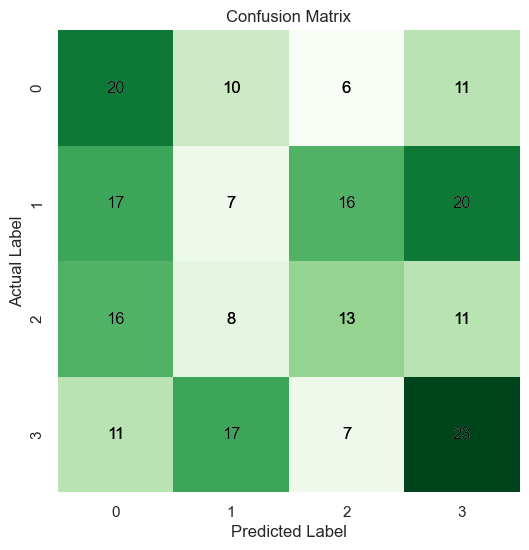

In [31]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, square=True)

# Add value annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, str(conf_matrix[i, j]), ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

This is much better, but note that the class labels are numeric. What do they mean? This is important. It turns out that these are not in the expected order. Let's create a new plot with the appropriate class labels.

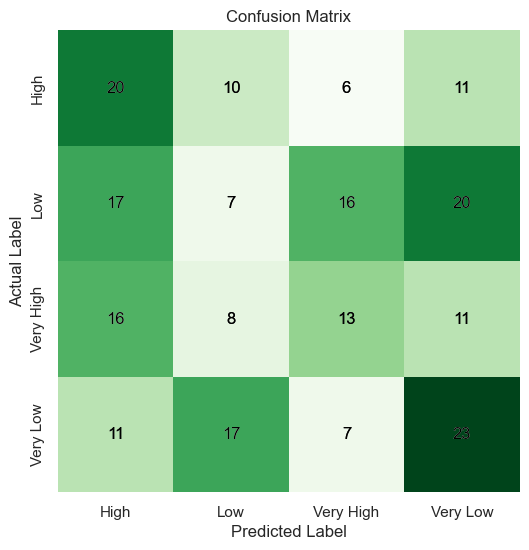

In [32]:
import numpy as np
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, square=True)

# Add value annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, str(conf_matrix[i, j]), ha='center', va='center', color='black')

# Fix tick labels
tick_labels = ['High', 'Low', 'Very High', 'Very Low']
plt.xticks(ticks=np.arange(0.5, len(tick_labels)), labels=tick_labels)
plt.yticks(ticks=np.arange(0.5, len(tick_labels)), labels=tick_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()


Note that here I have things ordered High, Low, Very High, Very Low. That is because the modelling process has encoded our categorical target variable to numeric values, but it has done so by first sorting our class labels in alphabetical order. 
The model excels in predicting classes designated as "low," likely attributed to a class imbalance. As a considerable majority of Dissemination Areas belong to the "low" category in terms of population change, the model may encounter challenges in learning and generalizing patterns for the less common classes. 


## Save the Model for Future Use

Using the `joblib` package, you can save your model for future use. This means you do not need to retrain your model every time you want to test it against new data. 

In [33]:
from joblib import dump

# Save the model to a file
dump(clf, 'C:\GDAA2000\Machine Learning Basics\models\model_1.joblib')

['C:\\GDAA2000\\Machine Learning Basics\\models\\model_1.joblib']

You can load your model using the following approach.

In [34]:
from joblib import load

# Load the model from the file
loaded_model = load('C:\GDAA2000\Machine Learning Basics\models\model_1.joblib')


## Test the Model on New Data

Now, finally, we can test our model on data that the model did not use in the training process. This will let us know how well our model has generalized. Did it simply memorize the pattern, or can it make accurate predictions?

In [35]:
# Extract the predictors from Newfoundland_DAs_test
X_test = Newfoundland_DAs_test.drop(columns=['Pop_Change_Quantiles'])

# Ensure that the column order in X_test matches the column order in X_train
X_test = X_test[X_train.columns]

# Make predictions using the loaded_model
predictions = loaded_model.predict(X_test)

# Display the predictions
print("Predictions on Newfoundland_DAs_test:")
print(predictions)



Predictions on Newfoundland_DAs_test:
['Very Low' 'High' 'Very Low']


To make this a bit clearer, let's put our predicted values next to the actual values.

In [36]:
import pandas as pd

# Extract the actual Food_Avg_Quantiles values from Halifax_DAs_test
actual_values = Newfoundland_DAs_test['Pop_Change_Quantiles']

# Create a DataFrame to store the actual and predicted values
predictions_df = pd.DataFrame({'Actual': actual_values, 'Predicted': predictions})

# Display the DataFrame
print("Predictions on Newfoundland_DAs_test:")
print(predictions_df)


Predictions on Newfoundland_DAs_test:
        Actual Predicted
999        Low  Very Low
617   Very Low      High
415  Very High  Very Low
